In [1]:
%matplotlib inline

import os
# needed to add for some weird jupyter notebook thing
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from numpy.random import default_rng
import copy
from PIL import Image
import cv2
import torchvision.transforms as transforms

### Setting seeds for repeatability

In [2]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed_all(0)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Defining model and extracting feature maps

StepImage basically does gradient updates to try to move images in the direction of a neuron's gradient

It's used to maximize a specific neuron's response to an image (for example, maximizing the response of a neuron looking for cat faces). Practically in our project, it could be used as an interpretability tool; people don't know what specific neurons are looking for bc deep networks are hard to undrstand, so if you morph an image to move in the direction of the patterns that a specific neuron is biased towards, you can see more clearly what that neuron is looking for.

Credit: written by 6.869 staff as code for a pset

In [3]:
class StepImage():
    def __init__(self, orig_input, step_size=2, is_normalized=True, 
               renorm=True, eps=30, norm_update='l2'):
        self.orig_input = orig_input
        if is_normalized:
            mean=[0.485, 0.456, 0.406]
            std= [0.229, 0.224, 0.225]
        else:
            mean=[0., 0., 0.]
            std= [1., 1., 1.]

        is_cuda = orig_input.is_cuda
        self.mean = torch.tensor(mean)[:, None, None]
        self.std = torch.tensor(std)[:, None, None]
        if is_cuda:
            self.mean = self.mean.cuda()
            self.std = self.std.cuda()
        self.eps = eps
        self.renorm = renorm
        self.step_size = step_size
        self.norm_update = norm_update

    def project(self, x):
        diff = x - self.orig_input
        if self.renorm:
            diff = diff.renorm(p=2, dim=0, maxnorm=self.eps)
        val_projected = self.orig_input + diff

        val_projected *= self.std
        val_projected += self.mean
        val_clamped = torch.clamp(val_projected, 0, 1)
        val_clamped -= self.mean
        val_clamped /= self.std
        return val_clamped

    # move one step in the direction of the neuron gradient
    def step(self, x, g):
        step_size = self.step_size
        # Scale g so that each element of the batch is at least norm 1
        if self.norm_update == 'l2':
            l = len(x.shape) - 1
            g_norm = torch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*l))
        else:
            g_norm = torch.torch.abs(g).mean()
        scaled_g = g / (g_norm + 1e-10)
        stepped = x + scaled_g * step_size
        projected = self.project(stepped)
        return projected

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def prepare_image(image_cv2, do_normalize=True):
    # Resize
    img = cv2.resize(image_cv2, (224, 224))
    img = img[:, :, ::-1].copy()
    # Convert to tensor
    tensor_img = transforms.functional.to_tensor(img)

    # Possibly normalize
    if do_normalize:
        tensor_img = normalize(tensor_img)
    # Put image in a batch
    batch_tensor_img = torch.unsqueeze(tensor_img, 0)
  
    # Put the image in the gpu
    if cuda_available:
        batch_tensor_img = batch_tensor_img.cuda()
    return batch_tensor_img

def UnNormalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]):
    std_arr = torch.tensor(std)[:, None, None]
    mean_arr = torch.tensor(mean)[:, None, None]
    def func(img):
        img = img.clone()
        img *= std_arr
        img += mean_arr
        return img
    return func

unnormalize = UnNormalize()

def obtain_image(tensor_img, do_normalize=True):
    tensor_img = tensor_img.cpu()
    if do_normalize:
        tensor_img = unnormalize(tensor_img)
    img = transforms.functional.to_pil_image((tensor_img.data))
    return img

In [5]:
# change between true and false to simulate what neurons are biased towards before training and after training
# we expect the results to be much more structured with a trained model
net = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


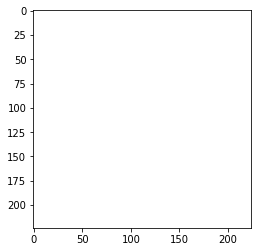

In [6]:
# this is our image that we're gonna perturb
# I chose a pure-white image bc it seems like results are decent with this
# but feel free to change if you find a better starting image

# img = torch.zeros((1, 3, 224, 224))
# img = torch.rand((1, 3, 224, 224))
img = torch.ones((1, 3, 224, 224))
plt.imshow(img[0].permute(1, 2, 0))

In [16]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [94]:
# modify to show different layers and channels
# there isn't really any semantic relationship between different channels like there is with different layers, 
# so we can just pick a couple of random channels per layer to show

# we expect outputs to look more meta (less locally-regular) as layer_id increases
layer_id = 5
# 207
# 889
channel_id = 889

In [95]:
# This function creates a function that gives the output of a given
# network at layer: layer_id.

def model_layer(model, layer_id):
    # These are the 4 sequential layers of resnet50
    layers = [model.layer1, model.layer2, model.layer3, model.layer4, model.avgpool, model.fc]  
    def forward(input):
        layers_used = layers[:(layer_id+1)]
        x = input
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.maxpool(x)
        for l in layers_used:
          if isinstance(l, nn.Linear) and layer_id == 5:
            # print(x.shape)
            num_channels, height, width, _ = x.shape
            x = x.view(num_channels, (height * width))
            # print(x.shape)
          x = l(x)
        return x
    return forward

In [ ]:
for param in net.parameters():
    param.requires_grad = False

# batch_tensor = img.clone().requires_grad_(True)
step = StepImage(img, step_size=0.05, renorm=False, norm_update='abs', is_normalized=False)

net_l = model_layer(net, layer_id)

for _ in tqdm(range(1000)):
    logit = net_l(batch_tensor)
    
    loss = torch.norm(logit[0,channel_id,...], p=2)
    gradient, = torch.autograd.grad(loss, batch_tensor)
    batch_tensor = step.step(batch_tensor, gradient)

  8%|▊         | 77/1000 [00:39<07:53,  1.95it/s]

In [ ]:
original_image = obtain_image(img[0, :], do_normalize=False)
modified_image = obtain_image(batch_tensor[0, :], do_normalize=False)

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Modified image (layer {layer_id}, channel {channel_id})')
ax.imshow(modified_image)